In [1]:
import OmicsUtils.DimRedMappers.clusterer
import OmicsUtils.DimRedMappers.umap_embedders
from importlib import reload
reload(OmicsUtils.DimRedMappers.clusterer)
reload(OmicsUtils.DimRedMappers.umap_embedders)

import pandas as pd 
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/anaconda3/envs/umap-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I. Data Preprocessing and transformation

## 1.1 Read and wrangle the data to get gene expression features and clinical data into a single dataframe

In [2]:
## Read labels and gene expression data 
fpkm_unstr_df_with_labels = pd.read_csv('./Transcriptomics/data/processed_data/fpkm_unstr_data_with_labels.csv')
gene_cols = fpkm_unstr_df_with_labels.columns.to_numpy()[:60660]
exposure_tsv = pd.read_csv('./Transcriptomics/data/clinical.cart.2023-10-29/exposure.tsv', sep='\t')


## some columns have whitespace that needs to be removed for better processing
new_columns = fpkm_unstr_df_with_labels.columns.str.replace(' ', '_').to_numpy()
fpkm_unstr_df_with_labels.columns = new_columns 

## Merge exposure data to get labels for tumor type and kidney subtype
ge_kidney_cancer_data_with_tgca_labels = pd.merge(fpkm_unstr_df_with_labels,
                                                  exposure_tsv[['case_submitter_id', 'project_id']],
                                                  left_on='Case_ID',
                                                  right_on='case_submitter_id')

## 1.2. Data transformation

Here, given we have RNA-Seq Gene expression data we apply some commonly applied data transformations

1. **Log transformation**: Gene expression values have a very wide range from (0, 500000) usually in the form of a spike-slab distribution. Hence need to tighten the range with a log transform
2. **Subsetting**: For purposes of this analysis we only want to look at 3 sub-types of kidney cancer samples ('TCGA-KIRC', 'TCGA-KICH', 'TCGA-KIRP')
3. **Label conversion**: Converting categorical labels into numerical labels for compatibility with machine learning algorithms

In [3]:
description_df = fpkm_unstr_df_with_labels.iloc[:, :60660].describe().reset_index()
showing_value_range = description_df[description_df['index'].isin(['min', 'mean', 'max'])].iloc[:,1:].values.flatten()


/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_11209/796282352.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(showing_value_range)


Text(0.5, 1.0, 'Distribution of min, mean, max of all gene expression values')

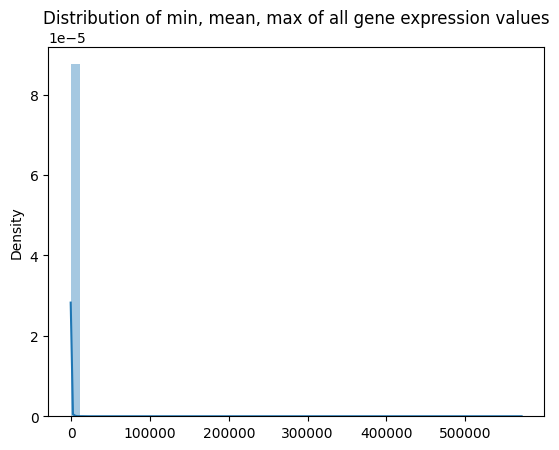

In [4]:
ax = sns.distplot(showing_value_range)
ax.set_title("Distribution of min, mean, max of all gene expression values" )

In [5]:

## Subset only 3 types of cancer sub-type from the dataset 
ge_kidney_cancer_data_correct_labels = (ge_kidney_cancer_data_with_tgca_labels[ge_kidney_cancer_data_with_tgca_labels['project_id'].isin(
    ['TCGA-KIRC', 'TCGA-KICH', 'TCGA-KIRP']
)]
)

## Apply log transformation
transformer = FunctionTransformer(np.log10)
ge_kidney_cancer_data_correct_labels[gene_cols] = ge_kidney_cancer_data_correct_labels[gene_cols] + 1
ge_kidney_cancer_data_correct_labels[gene_cols] = transformer.fit_transform(ge_kidney_cancer_data_correct_labels[gene_cols])

## Convert categorical labels to numerical labels 
columns_for_one_hot = ['project_id', 'Sample_Type']
ml_df = pd.get_dummies(ge_kidney_cancer_data_correct_labels, columns=['project_id', 'Sample_Type'], prefix=['cancer_subtype', 'tumor_subtype'])

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_11209/1726230766.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_kidney_cancer_data_correct_labels[gene_cols] = ge_kidney_cancer_data_correct_labels[gene_cols] + 1
/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_11209/1726230766.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_kidney_cancer_data_correct_labels[gene_cols] = transformer.fit_transform(ge_kidney_cancer_data_correct_labels[gene_cols])


In [6]:
columns_for_one_hot = ['project_id', 'Sample_Type']
ge_kidney_cancer_data_correct_labels['project_id_orig'] =ge_kidney_cancer_data_correct_labels['project_id']
ge_kidney_cancer_data_correct_labels['Sample_Type_orig'] = ge_kidney_cancer_data_correct_labels['Sample_Type']
ml_df = pd.get_dummies(ge_kidney_cancer_data_correct_labels, columns=['project_id', 'Sample_Type'], prefix=['cancer_subtype', 'tumor_subtype'])


/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_11209/2156470527.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ge_kidney_cancer_data_correct_labels['project_id_orig'] =ge_kidney_cancer_data_correct_labels['project_id']
/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_11209/2156470527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_kidney_cancer_data_correct_labels['project_id_orig'] =ge_kidney_cancer_data_correct_labels['project_id']
/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ip

## II. Exploratory Analysis

## 2.1 Check overall info of datatypes, null values

In [7]:
ge_kidney_cancer_data_correct_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924 entries, 2 to 1293
Columns: 60673 entries, ENSG00000000003.15 to Sample_Type_orig
dtypes: float64(60660), object(13)
memory usage: 427.7+ MB


## 2.2. Check Unique sample IDs

In [8]:
print(f"The total patient ids are {ge_kidney_cancer_data_correct_labels['Case_ID'].count()}, from those the unique ids are {ge_kidney_cancer_data_correct_labels['Case_ID'].value_counts().shape[0]} ")

The total patient ids are 924, from those the unique ids are 799 


## 2.3. Check number of data labels by project type and tumor type

In [9]:
ge_kidney_cancer_data_correct_labels.groupby(['Sample_Type'])['Sample_Type'].count()

Sample_Type
Additional - New Primary      2
Primary Tumor               800
Solid Tissue Normal         122
Name: Sample_Type, dtype: int64

[Text(0, 0, '800'), Text(0, 0, '122'), Text(0, 0, '2')]

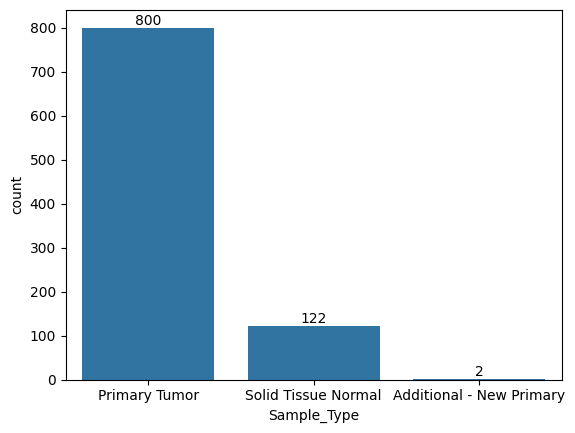

In [10]:
ax = sns.countplot(x='Sample_Type', data=ge_kidney_cancer_data_correct_labels)
ax.bar_label(ax.containers[0])


In [11]:
ge_kidney_cancer_data_correct_labels.groupby(['project_id'])['project_id'].count()

project_id
TCGA-KICH     84
TCGA-KIRC    539
TCGA-KIRP    301
Name: project_id, dtype: int64

[Text(0, 0, '539'), Text(0, 0, '301'), Text(0, 0, '84')]

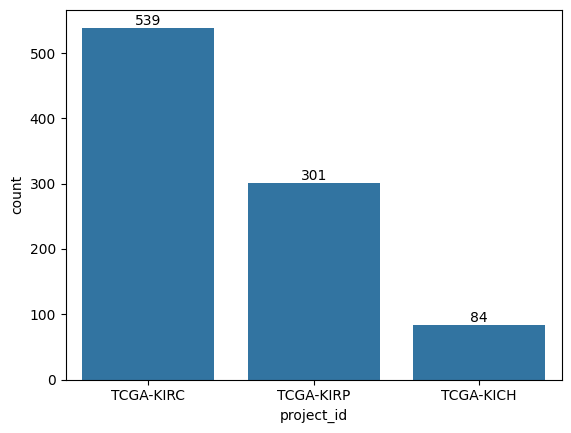

In [12]:
ax = sns.countplot(x='project_id', data=ge_kidney_cancer_data_correct_labels)
ax.bar_label(ax.containers[0])


## III. Data sampling, Augmentation and splitting into training, testing and validation sets for Supervised Clustering 

Given that we have imbalanced datasets for Tumor Types and Kidney Cancer subtypes (project_id), we should consider the following for an **unbiased analysis** 

1. **Patient overlap**: Given 924 total patients with 799 unique, 
   
   <br>

   1. We should keep same ID patients in only one set i.e (Training or Validation or Testing)
   2. Preferably, we should have have all overlapping patients in Testing so as to not bias our training 

<br>

2. **Set Sampling**: For minority classes, we sample atleast X% into our testing first followed by validation and then all the remaining in training.

3. Additionally for one of the minority classes (New Primary - we should group it into the same category as Primary)

4. **Data augmention**: Applying oversampling, undersampling techniques for minority or majority classes 

## 3.1. Label correction of Additional - New Primary tumor

In [13]:
ge_kidney_cancer_data_correct_labels['Sample_Type'] = ge_kidney_cancer_data_correct_labels['Sample_Type'].apply(lambda x: 'Primary Tumor' if x == 'Additional - New Primary' else x)

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_11209/2849659451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_kidney_cancer_data_correct_labels['Sample_Type'] = ge_kidney_cancer_data_correct_labels['Sample_Type'].apply(lambda x: 'Primary Tumor' if x == 'Additional - New Primary' else x)


In [14]:
ge_kidney_cancer_data_correct_labels.groupby(['Sample_Type'])['Sample_Type'].count()

Sample_Type
Primary Tumor          802
Solid Tissue Normal    122
Name: Sample_Type, dtype: int64

[Text(0, 0, '802'), Text(0, 0, '122')]

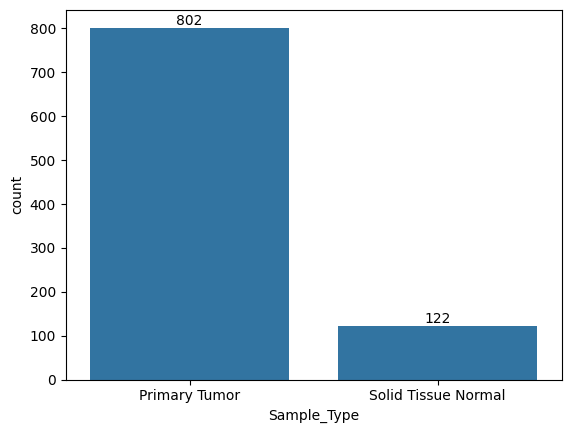

In [15]:
ax = sns.countplot(x='Sample_Type', data=ge_kidney_cancer_data_correct_labels)
ax.bar_label(ax.containers[0])


## 3.2 Separation of training, validation and testing data for unbiased analysis

Strategy
1. Find pairs of all duplicate sample IDs and randomly sample pairs 70% in training, 20% in validation and 10% in testing (with seed)
2. Out of the remaining samples For the 2 lowest groups KICH (10% - 84 samples) and Solid tissue(13% - 122 samples) put more than 25% samples into testing set first 
   1. Take union of 21 samples from KICH (25%) and 30 samples from Solid tissue (25%)  and put all those samples into testing set first
   2. Hold out this set till model training has occurred 
   3. Out of the remaining samples, again put more than 25% samples from minority classes into validation
   4. Put all the remaining into training 


In [16]:
from sklearn.model_selection import train_test_split


In [17]:
y_true = ml_df.iloc[:, -6:].drop(['tumor_subtype_Additional - New Primary'], axis=1).astype(int).to_numpy()

In [18]:
# Count of each unique value
value_counts = ml_df['Case_ID'].value_counts()

# list of duplicate ids
duplicate_ids = value_counts[value_counts > 1].reset_index()['Case_ID'].unique()

## 3.2.1 Separating patient overlap samples

In [19]:
# First split: Separate out a test set
train_val_ids, test_overlap_ids = train_test_split(duplicate_ids, test_size=0.1, random_state=42)

# Second split: Separate the remaining data into training and validation sets
train_overlap_ids, val_overlap_ids = train_test_split(train_val_ids, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print(f"Number of Patient overlap Training IDs: {len(train_overlap_ids)}")
print(f"Number of Patient overlap Validation IDs: {len(val_overlap_ids)}")
print(f"Number of Patient overlap Testing IDs: {len(test_overlap_ids)}")

Number of Patient overlap Training IDs: 87
Number of Patient overlap Validation IDs: 22
Number of Patient overlap Testing IDs: 13


## 3.2.2 Set sampling

Shows that majority of duplicate samples came from the Solid tissue class

In [20]:
ml_df_without_overlap = ml_df[~ml_df['Case_ID'].isin(duplicate_ids)].reset_index(drop=True)

Text(0.5, 1.0, 'Count of samples originally across tumors')

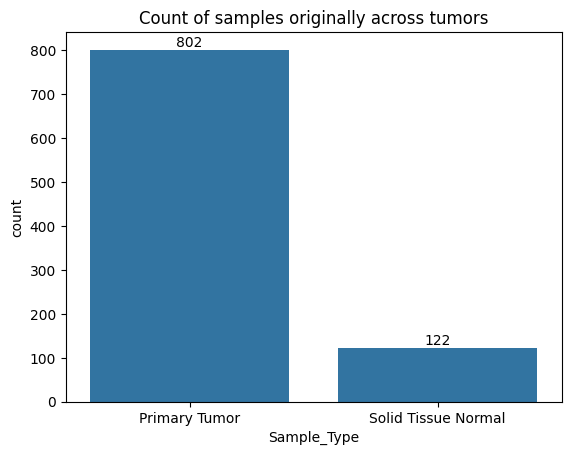

In [21]:
ax1 = sns.countplot(x='Sample_Type', data=ge_kidney_cancer_data_correct_labels)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Count of samples originally across tumors")

Text(0.5, 1.0, 'Count of samples after separating patient overlap samples')

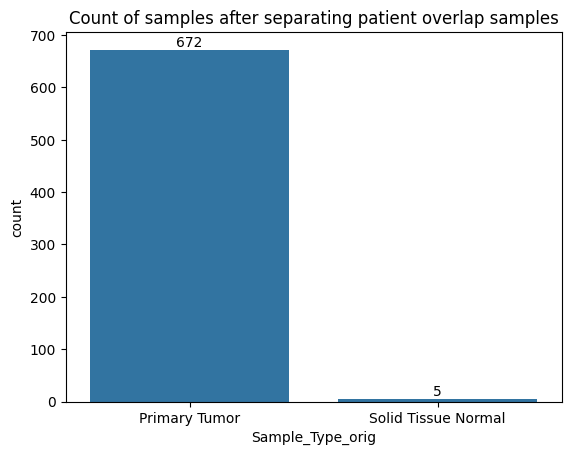

In [22]:
ax = sns.countplot(x='Sample_Type_orig', data=ml_df_without_overlap )
ax.bar_label(ax.containers[0])
ax.set_title("Count of samples after separating patient overlap samples")


Text(0.5, 1.0, 'Samples Count in Kidney cancer(KC) subtypes Originally')

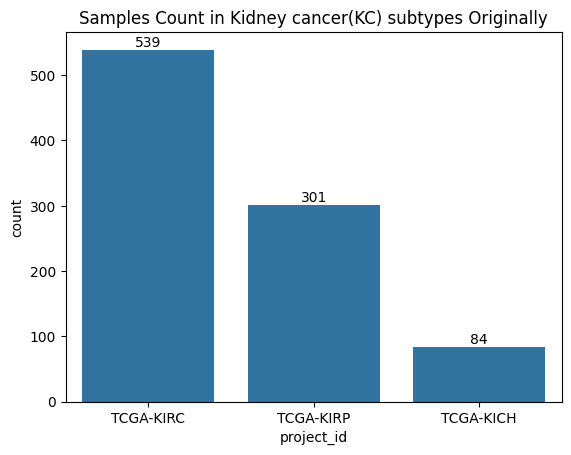

In [23]:
ax = sns.countplot(x='project_id', data=ge_kidney_cancer_data_correct_labels)
ax.bar_label(ax.containers[0])
ax.set_title("Samples Count in Kidney cancer(KC) subtypes Originally")

Text(0.5, 1.0, 'Samples count in KC subtypes after separating patient overlap')

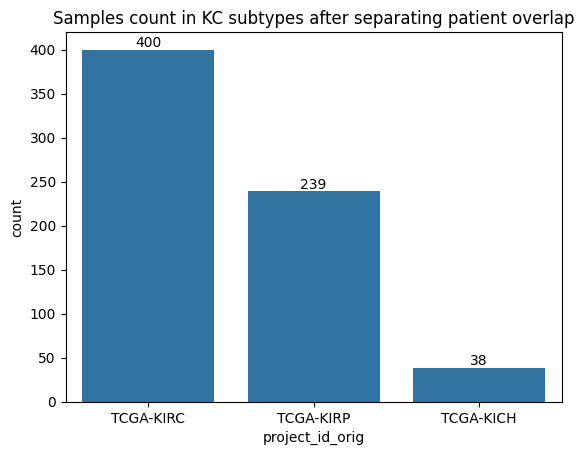

In [24]:
ax = sns.countplot(x='project_id_orig', data=ml_df_without_overlap)
ax.bar_label(ax.containers[0])
ax.set_title("Samples count in KC subtypes after separating patient overlap")

In [25]:
all_minority_samples1 = ml_df_without_overlap[(ml_df_without_overlap['Sample_Type_orig'] == 'Solid Tissue Normal')
| (ml_df_without_overlap['project_id_orig'] == 'TCGA-KICH')]['Case_ID'].to_numpy()

# First split: Separate out a test set with 50% 
train_val_set_sampl_ids1, test_set_samp_ids1 = train_test_split(all_minority_samples1, test_size=0.5, random_state=42)

# Second split: Separate the remaining data into training and validation sets
train_set_samp_ids1, val_set_samp_ids1 = train_test_split(train_val_set_sampl_ids1, test_size=0.5, random_state=42) 

print(f"Number of Minority set sampled Training IDs: {len(train_set_samp_ids1)}")
print(f"Number of Minority set sampled  Validation IDs: {len(val_set_samp_ids1)}")
print(f"Number of Minority set sampled  Testing IDs: {len(test_set_samp_ids1)}")

Number of Minority set sampled Training IDs: 10
Number of Minority set sampled  Validation IDs: 11
Number of Minority set sampled  Testing IDs: 21


In [26]:
rem_majority_samples = ml_df_without_overlap[~ml_df_without_overlap['Case_ID'].isin(all_minority_samples1)]['Case_ID'].to_numpy()

# First split: Separate out a test set
train_val_major_ids1, test_major_ids1 = train_test_split(rem_majority_samples, test_size=0.1, random_state=42)

# Second split: Separate the remaining data into training and validation sets
train_major_ids1, val_major_ids1 = train_test_split(train_val_major_ids1, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print(f"Number of majority classes Training IDs: {len(train_major_ids1)}")
print(f"Number of majority classes Validation IDs: {len(val_major_ids1)}")
print(f"Number of majority classes Testing IDs: {len(test_major_ids1)}")

Number of majority classes Training IDs: 456
Number of majority classes Validation IDs: 115
Number of majority classes Testing IDs: 64


In [27]:
train_ids_df = pd.DataFrame({'Case_ID': list(train_overlap_ids) + list(train_major_ids1) + list(train_set_samp_ids1)}).assign(label='training')
val_ids_df = pd.DataFrame({'Case_ID': list(val_overlap_ids) + list(val_major_ids1) + list(val_set_samp_ids1)}).assign(label='validation')
test_ids_df = pd.DataFrame({'Case_ID': list(test_overlap_ids) + list(test_major_ids1) + list(test_set_samp_ids1)}).assign(label='testing') 
train_val_test_ids_df = pd.concat([train_ids_df, val_ids_df, test_ids_df], axis=0)

In [28]:
train_val_test_ids_df = pd.merge(train_val_test_ids_df, ml_df[['Case_ID', 'project_id_orig', 'Sample_Type_orig']],
left_on='Case_ID',
right_on='Case_ID')

In [29]:
train_val_test_ids_df 

,Case_ID,label,project_id_orig,Sample_Type_orig
0,TCGA-CW-5585,training,TCGA-KIRC,Primary Tumor
1,TCGA-CW-5585,training,TCGA-KIRC,Solid Tissue Normal
2,TCGA-B0-5706,training,TCGA-KIRC,Solid Tissue Normal
3,TCGA-B0-5706,training,TCGA-KIRC,Primary Tumor
4,TCGA-DZ-6132,training,TCGA-KIRP,Solid Tissue Normal
...,...,...,...,...
919,TCGA-KN-8418,testing,TCGA-KICH,Primary Tumor
920,TCGA-KO-8406,testing,TCGA-KICH,Primary Tumor
921,TCGA-KO-8414,testing,TCGA-KICH,Primary Tumor
922,TCGA-KL-8325,testing,TCGA-KICH,Primary Tumor


In [30]:
train_val_test_ids_df[['label', 'project_id_orig']].value_counts()

label       project_id_orig
training    TCGA-KIRC          394
            TCGA-KIRP          215
validation  TCGA-KIRC           96
            TCGA-KIRP           51
testing     TCGA-KIRC           49
            TCGA-KIRP           35
training    TCGA-KICH           34
testing     TCGA-KICH           27
validation  TCGA-KICH           23
Name: count, dtype: int64

In [31]:
train_val_test_ids_df[['label', 'Sample_Type_orig']].value_counts()

label       Sample_Type_orig        
training    Primary Tumor               556
validation  Primary Tumor               148
testing     Primary Tumor                96
training    Solid Tissue Normal          86
validation  Solid Tissue Normal          21
testing     Solid Tissue Normal          15
training    Additional - New Primary      1
validation  Additional - New Primary      1
Name: count, dtype: int64

In [32]:
print(f"Final train-validation-test split dataframe has {train_val_test_ids_df.shape[0]} unique samples")

Final train-validation-test split dataframe has 924 unique samples


## IV. Apply multi-label classification on all features 

Objectives: 

- Here we will train different classification models on the data with no embeddings

- Address class imbalance (2 options):
  - Modify loss functions of different classifiers for imbalanced training and testing data 
  - Re-sampling of minority class in each of training and validation sets 
  

- Evaluate performance of different classifiers in training and validation cycle 

- Rank features using shapley values


In [33]:
y_label_cols = ['cancer_subtype_TCGA-KICH', 'cancer_subtype_TCGA-KIRC',
       'cancer_subtype_TCGA-KIRP', 
       'tumor_subtype_Primary Tumor', 'tumor_subtype_Solid Tissue Normal']
X_train = ml_df[ml_df['Case_ID'].isin(train_val_test_ids_df[train_val_test_ids_df['label'] == 'training']['Case_ID'].to_numpy())][gene_cols].to_numpy()
y_train = ml_df[ml_df['Case_ID'].isin(train_val_test_ids_df[train_val_test_ids_df['label'] == 'training']['Case_ID'].to_numpy())][y_label_cols].astype(int).to_numpy()

In [34]:
y_label_cols = ['cancer_subtype_TCGA-KICH', 'cancer_subtype_TCGA-KIRC',
       'cancer_subtype_TCGA-KIRP', 
       'tumor_subtype_Primary Tumor', 'tumor_subtype_Solid Tissue Normal']
X_val = ml_df[ml_df['Case_ID'].isin(train_val_test_ids_df[train_val_test_ids_df['label'] == 'validation']['Case_ID'].to_numpy())][gene_cols].to_numpy()
y_val = ml_df[ml_df['Case_ID'].isin(train_val_test_ids_df[train_val_test_ids_df['label'] == 'validation']['Case_ID'].to_numpy())][y_label_cols].astype(int).to_numpy()

# X_val_umap = plane_mapper.fit_transform(X_val) 

In [35]:
y_label_cols = ['cancer_subtype_TCGA-KICH', 'cancer_subtype_TCGA-KIRC',
       'cancer_subtype_TCGA-KIRP',
       'tumor_subtype_Primary Tumor', 'tumor_subtype_Solid Tissue Normal']
X_test = ml_df[ml_df['Case_ID'].isin(train_val_test_ids_df[train_val_test_ids_df['label'] == 'testing']['Case_ID'].to_numpy())][gene_cols].to_numpy()
y_test = ml_df[ml_df['Case_ID'].isin(train_val_test_ids_df[train_val_test_ids_df['label'] == 'testing']['Case_ID'].to_numpy())][y_label_cols].astype(int).to_numpy()



## 4.2. Apply multiple classification Models to train and evaluate performance

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve
from itertools import cycle
from sklearn.metrics import multilabel_confusion_matrix

In [37]:
# svc = SVC(gamma='auto', random_state=42, kernel='radial') #instantiate the base model
clf_svc = MultiOutputClassifier(SVC(kernel="rbf", C=0.025, random_state=42))
clf_lg = MultiOutputClassifier(LogisticRegression(solver='liblinear', penalty='l1', random_state=42))
clf_dtc = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))
clf_rf = MultiOutputClassifier(RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ))
clf_gnb = MultiOutputClassifier(GaussianNB())
clf_knn = MultiOutputClassifier(KNeighborsClassifier())
clf_ada = MultiOutputClassifier(AdaBoostClassifier())
modelclasses = [
    ["log regression", clf_lg],
    ["decision tree", clf_dtc],
    ["random forest", clf_rf],
    ["k neighbors", clf_knn],
    ["naive bayes", clf_gnb],
    ["support vector machines", clf_svc],
    ["Adaboost", clf_ada]
]

## 4.2.1 Training of 7 models 

In [38]:
preds_lg_train_all = {}
preds_lg_val_all = {}

for model, clf_i in modelclasses:
    clf_i.fit(X_train, y_train)
    preds_lg_val_i = clf_i.predict(X_val) #predict target
    preds_lg_train_i =clf_i.predict(X_train)

    preds_lg_train_all[model] = preds_lg_train_i
    preds_lg_val_all[model] = preds_lg_val_i

## 4.2.2. Plot ROC curves for all classifiers training and testing performance

## 4.2.2.1 Micro averaged ROC's

In [39]:
def roc_plot(y_val, preds_val, name, color, plot_chance_level, ax):
    RocCurveDisplay.from_predictions(
        y_val.ravel(),
        preds_val.ravel(),
        name=name,
        color=color,
        plot_chance_level=plot_chance_level,
        ax=ax
    )
    return 

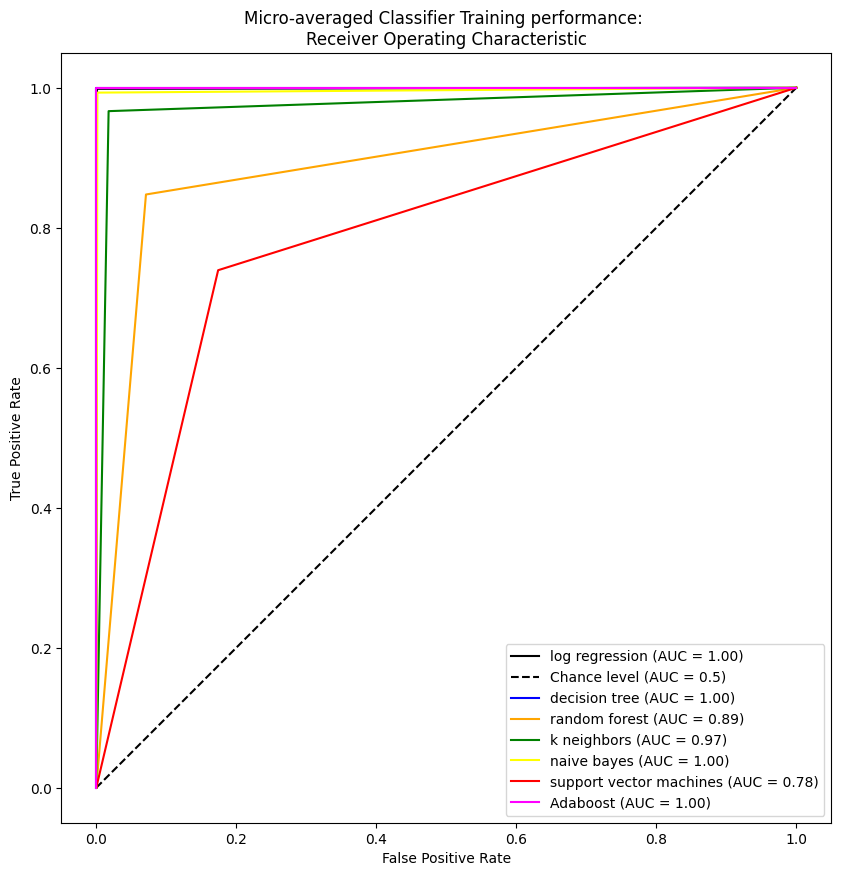

In [40]:
colors = ['black', 'blue', 'orange', 'green', 'yellow', 'red', 'magenta']

i = 0
fig, ax = plt.subplots(figsize=(10, 10))
for model, clf_i in modelclasses:
    if i == 0:
        roc_plot(y_val=y_train, preds_val=preds_lg_train_all[model], name=model, color=colors[i], plot_chance_level=True, ax=ax)
    else:
       roc_plot(y_val=y_train, preds_val=preds_lg_train_all[model], name=model, color=colors[i], plot_chance_level=False, ax=ax) 
    i += 1

# RocCurveDisplay.from_predictions(
#     y_train.ravel(),
#     preds_lg_train.ravel(),
#     name="micro-average OvR train",
#     color="blue",
#     plot_chance_level=True,
#     ax=ax
# )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged Classifier Training performance: \nReceiver Operating Characteristic")
plt.legend()
plt.show()

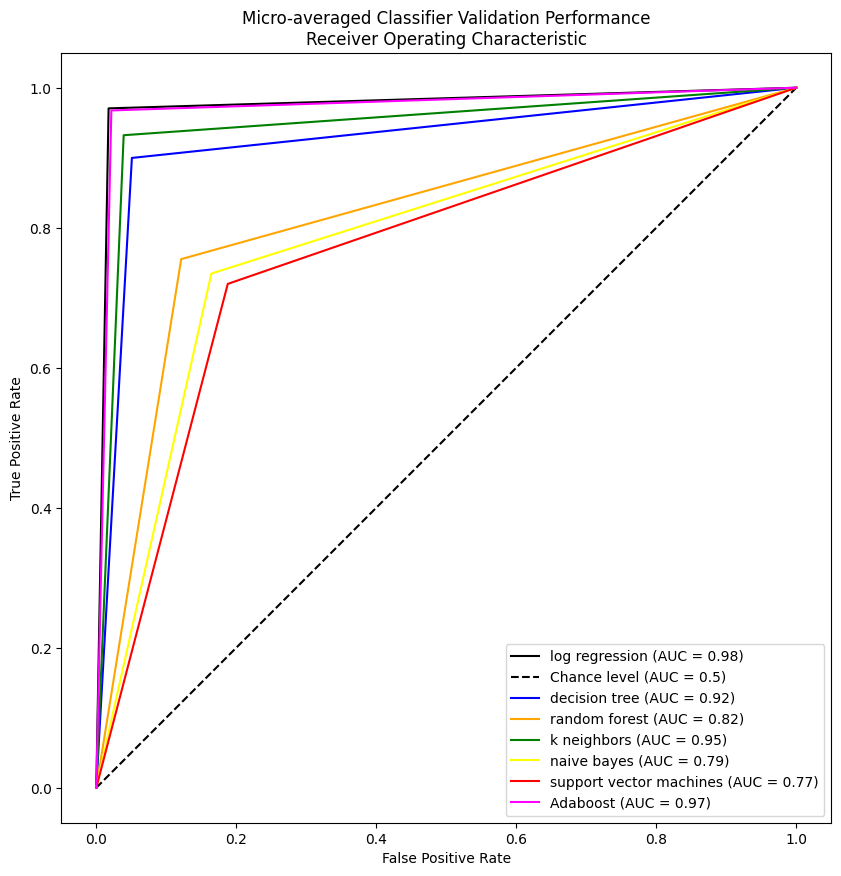

In [41]:
colors = ['black', 'blue', 'orange', 'green', 'yellow', 'red', 'magenta']

i = 0
fig, ax = plt.subplots(figsize=(10, 10))
for model, clf_i in modelclasses:
    if i == 0:
        roc_plot(y_val=y_val, preds_val=preds_lg_val_all[model], name=model, color=colors[i], plot_chance_level=True, ax=ax)
    else:
       roc_plot(y_val=y_val, preds_val=preds_lg_val_all[model], name=model, color=colors[i], plot_chance_level=False, ax=ax) 
    i += 1

# RocCurveDisplay.from_predictions(
#     y_train.ravel(),
#     preds_lg_train.ravel(),
#     name="micro-average OvR train",
#     color="blue",
#     plot_chance_level=True,
#     ax=ax
# )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged Classifier Validation Performance\nReceiver Operating Characteristic")
plt.legend()
plt.show()

## 4.2.2.2 Macro averaged ROC's 

In [42]:
def macro_roc_calc(y_true, y_pred):
    macro_roc_auc_ovr = roc_auc_score(
        y_true,
        y_pred,
        multi_class="ovr",
        average="macro",
    )
    return macro_roc_auc_ovr

for model, clf_i in modelclasses:
    macro_roc_i = macro_roc_calc(y_val, preds_lg_val_all[model])
    print(f"Macro-averaged One-vs-Rest ROC AUC score for {model}:\n{macro_roc_i:.2f}")

Macro-averaged One-vs-Rest ROC AUC score for log regression:
0.96
Macro-averaged One-vs-Rest ROC AUC score for decision tree:
0.89
Macro-averaged One-vs-Rest ROC AUC score for random forest:
0.59
Macro-averaged One-vs-Rest ROC AUC score for k neighbors:
0.91
Macro-averaged One-vs-Rest ROC AUC score for naive bayes:
0.53
Macro-averaged One-vs-Rest ROC AUC score for support vector machines:
0.50
Macro-averaged One-vs-Rest ROC AUC score for Adaboost:
0.96


## 4.2.2.3 Comparison of macro vs micro for best classifier (LR) 

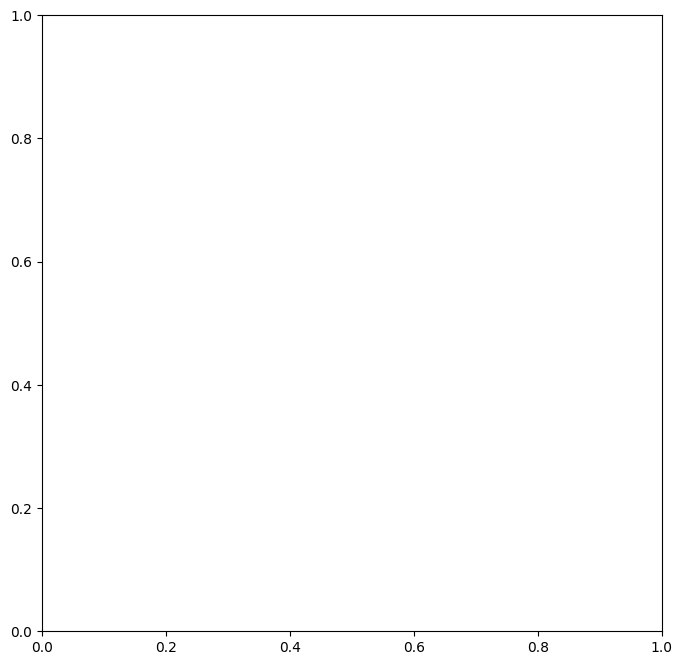

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
def create_roc_micro_vs_macro_plot(y_val, preds_lg_val_all, model, ax):
    n_classes = 5
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), preds_lg_val_all[model].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], preds_lg_val_all[model][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    ax.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
        
    )

    ax.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,

    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "pink"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_val[:, class_id],
            preds_lg_val_all[model][:, class_id],
            name=f"ROC curve for {y_label_cols[class_id].split('subtype_')[1]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model}")
    ax.legend(bbox_to_anchor =(0.5,-0.77), loc='lower center')
    return


Macro-averaged One-vs-Rest ROC AUC score for log regression:
0.96
Micro-averaged One-vs-Rest ROC AUC score:
0.98
Macro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score for decision tree:
0.89
Micro-averaged One-vs-Rest ROC AUC score:
0.92
Macro-averaged One-vs-Rest ROC AUC score:
0.89
Macro-averaged One-vs-Rest ROC AUC score for k neighbors:
0.91
Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.91
Macro-averaged One-vs-Rest ROC AUC score for Adaboost:
0.96
Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.96


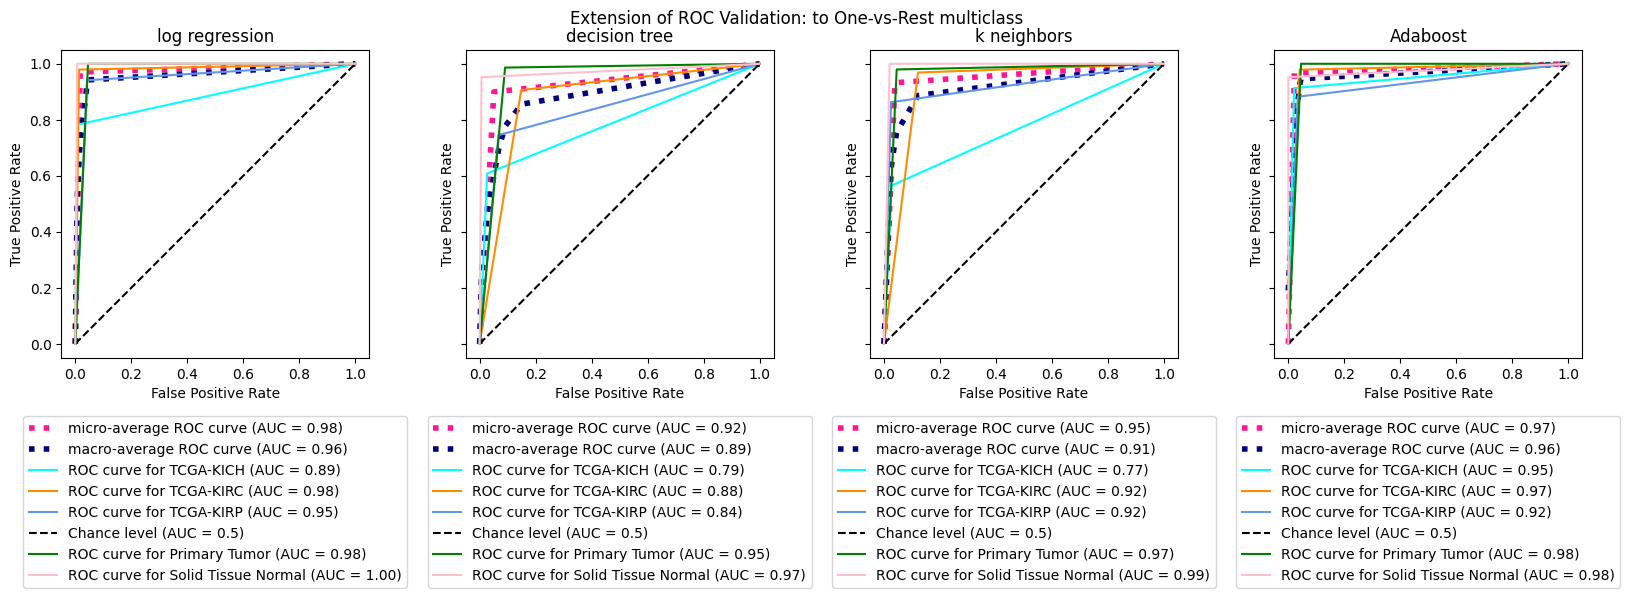

In [44]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
fig.suptitle('Extension of ROC Validation: to One-vs-Rest multiclass')
i = 0
best_model_classes =[["log regression", clf_lg],
    ["decision tree", clf_dtc],
    # ["random forest", clf_rf],
    ["k neighbors", clf_knn],
    # ["naive bayes", clf_gnb],
    # ["support vector machines", clf_svc],
    ["Adaboost", clf_ada]]

for model, clf_i in best_model_classes:
    if i == 4:
        break
    else:
        macro_roc_i = macro_roc_calc(y_val, preds_lg_val_all[model])
        print(f"Macro-averaged One-vs-Rest ROC AUC score for {model}:\n{macro_roc_i:.2f}")   
        create_roc_micro_vs_macro_plot(y_val, preds_lg_val_all, model, ax=axes[i])
    i += 1

## Next steps 


4.2.3. Evaluation of Sensitivity at 99% specificity for best performing models:

- Swarmplots of diseases by categories for best performing models
- Currently 4 models show AUC-ROC > 0.9 based on micro-averaging. Hence for each of the models across the 5 sets of categories (Primary Tumor, Solid Tissue Normal, KICH, KIRP, KIRC), we want to plot swarm plots in a single plot for each of training and testing 
- Plot area (4, 5): Each row will have the classifier and column will have the category and plot of 0, 1 across each plot 
  




## 4.2.3. Evaluating feature importances from training and validation for best performing model

- Basic feature importances 
- Shapley values

In [78]:
gene_id_to_gene_name_map = pd.read_csv('./Transcriptomics/data/gene_annotation/gene_id_to_gene_name_mapping.csv')

In [46]:
feat_importances = []
for clf_ij in clf_i.estimators_:
    f_imp_i = clf_ij.feature_importances_
    feat_importances.append(f_imp_i)

In [86]:
clf_lg_0 = clf_lg.estimators_[1]

In [87]:
coefficients = clf_lg_0.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature':gene_cols, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance_gene_name = pd.merge(feature_importance, gene_id_to_gene_name_map,
                                        left_on='Feature',
                                        right_on='gene_id')


In [88]:
feature_importance_gene_name 

,Feature,Importance,gene_id,gene_name
0,ENSG00000000003.15,0.000000,ENSG00000000003.15,TSPAN6
1,ENSG00000252459.1,0.000000,ENSG00000252459.1,AC026765.1
2,ENSG00000252460.1,0.000000,ENSG00000252460.1,RNU6-635P
3,ENSG00000252461.1,0.000000,ENSG00000252461.1,AC133550.1
4,ENSG00000252462.1,0.000000,ENSG00000252462.1,RNU6-113P
...,...,...,...,...
60655,ENSG00000214145.7,0.954114,ENSG00000214145.7,LINC00887
60656,ENSG00000236439.4,0.962582,ENSG00000236439.4,AC099336.2
60657,ENSG00000197582.5,1.422640,ENSG00000197582.5,GPX1P1
60658,ENSG00000239559.2,1.829407,ENSG00000239559.2,RPL37P2


In [89]:
feature_importance_gene_name.sort_values(['Importance'], ascending=False).iloc[:20, :]

,Feature,Importance,gene_id,gene_name
60659,ENSG00000206228.4,1.953389,ENSG00000206228.4,HNRNPA1P4
60658,ENSG00000239559.2,1.829407,ENSG00000239559.2,RPL37P2
60657,ENSG00000197582.5,1.422640,ENSG00000197582.5,GPX1P1
60656,ENSG00000236439.4,0.962582,ENSG00000236439.4,AC099336.2
60655,ENSG00000214145.7,0.954114,ENSG00000214145.7,LINC00887
60654,ENSG00000220842.6,0.941041,ENSG00000220842.6,RPL21P16
60653,ENSG00000186076.5,0.937614,ENSG00000186076.5,AC012085.1
60652,ENSG00000162840.4,0.834495,ENSG00000162840.4,MT2P1
60651,ENSG00000253683.1,0.766205,ENSG00000253683.1,AC027309.2
60650,ENSG00000100867.15,0.730470,ENSG00000100867.15,DHRS2


## 5.0 Evaluating Performance on Held out test set by Logistic Regression and AdaBoost models

In [74]:
best_model_classes_for_testing =[["log regression", clf_lg],
    # ["decision tree", clf_dtc],
    # ["random forest", clf_rf],
    # ["k neighbors", clf_knn],
    # ["naive bayes", clf_gnb],
    # ["support vector machines", clf_svc],
    ["Adaboost", clf_ada]]
preds_y_testing = {}
for model, clf_i in best_model_classes_for_testing:
    preds_y = clf_i.predict(X_test)
    preds_y_testing[model] = preds_y

Macro-averaged One-vs-Rest ROC AUC score for log regression:
0.95
Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score for Adaboost:
0.95
Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.95


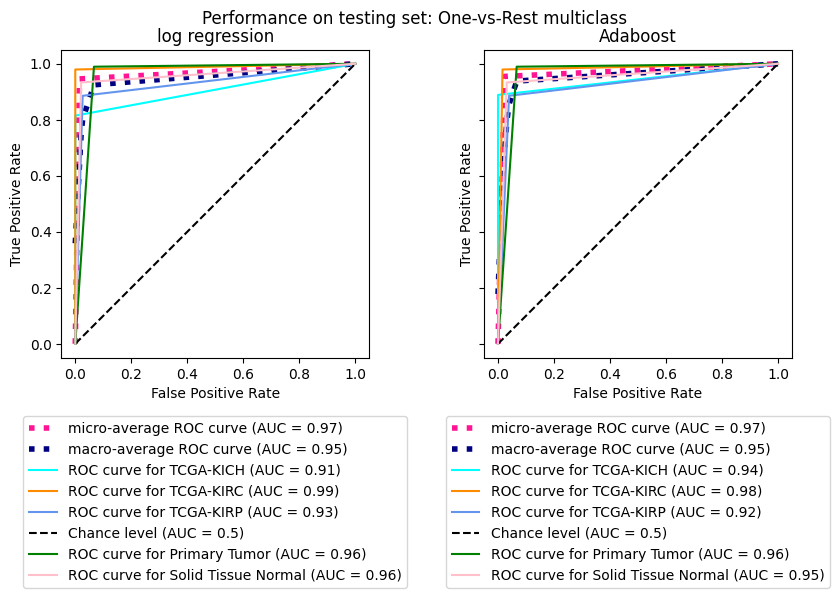

In [77]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))
fig.suptitle('Performance on testing set: One-vs-Rest multiclass')
i = 0
for model, clf_i in best_model_classes_for_testing:
    if i == 4:
        break
    else:
        macro_roc_i = macro_roc_calc(y_test, preds_y_testing[model])
        print(f"Macro-averaged One-vs-Rest ROC AUC score for {model}:\n{macro_roc_i:.2f}")   
        create_roc_micro_vs_macro_plot(y_test, preds_y_testing, model, ax=axes[i])
    i += 1

In [194]:
# from sklearn.metrics import multilabel_confusion_matrix
# def get_performance_metrics(Tp, FP, TN, FN):
#     # Sensitivity, hit rate, recall, or true positive rate
#     TPR = TP/(TP+FN)
#     # Specificity or true negative rate
#     TNR = TN/(TN+FP) 
#     # Precision or positive predictive value
#     PPV = TP/(TP+FP)
#     # Negative predictive value
#     NPV = TN/(TN+FN)
#     # Fall out or false positive rate
#     FPR = FP/(FP+TN)
#     # False negative rate
#     FNR = FN/(TP+FN)
#     # False discovery rate
#     FDR = FP/(TP+FP)
#     # Overall accuracy for each class
#     ACC = (TP+TN)/(TP+FP+FN+TN)
#     performance_metrics = {'True positive rate': TPR,
#                            'True negative rate': TNR,
#                            'Positive predictive value': PPV,
#                            'Negative predictive value': NPV,
#                            'False positive rate': FPR,
#                            'False negative rate': FNR,
#                            'False discovery rate': FDR,
#                            'Accuracy': ACC
#     }
#     return performance_metrics
# fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(16,8))
# fig.suptitle('3 rows x 4 columns axes with no data')
